# ML Workshop 1: General ML
# Data Analysis

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from collections import defaultdict, OrderedDict, Counter
import copy
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from datetime import date, datetime
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load and print some data

In [3]:
df = pd.read_csv("/data/cardataset.zip")
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
5,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,31200
6,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,26,17,3916,44100
7,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,39300
8,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,36900
9,BMW,1 Series,2013,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,27,18,3916,37200


In [4]:
df.shape

(11914, 16)

# Check data types

In [5]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

All types as expected, sometimes mixing int and float but it doesn't matter so much.

In [6]:
numerical = [col for col, type_ in df.dtypes.items() if type_ in (np.int64, np.float64)]
categorical = [col for col, type_ in df.dtypes.items() if col not in numerical]

print("numerical", numerical)
print("categorical", categorical)

numerical ['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']
categorical ['Make', 'Model', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Market Category', 'Vehicle Size', 'Vehicle Style']


In [7]:
df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


- Missing data at columns "Engine HP", "Engine Cylinders", "Number of Doors"
- max(Year) = 2017, dataset published on Dec 2016, some data for future
- std > 0 for all columns => not constant columns
- min(Engine Cylinders) = 0 => weird

Don't understand MPG, transform to l/100km

In [8]:
def mpg_to_l100km(mpg):
    return 235.21 / mpg

min_mpg = min(min(df["city mpg"]), min(df["highway MPG"]))
max_mpg =  min(max(df["city mpg"]), max(df["highway MPG"]))

print("Min {}mpg, {} l/100km".format(min_mpg, mpg_to_l100km(min_mpg)))
print("Max {}mpg, {} l/100km".format(max_mpg, mpg_to_l100km(max_mpg)))

Min 7mpg, 33.60142857142857 l/100km
Max 137mpg, 1.7168613138686133 l/100km


0.66 l/100 km strange but might be OK

# Histograms

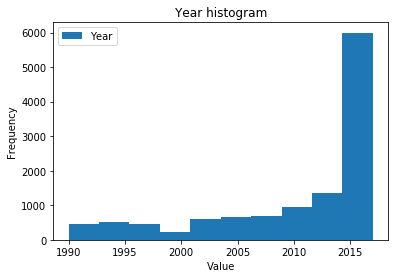

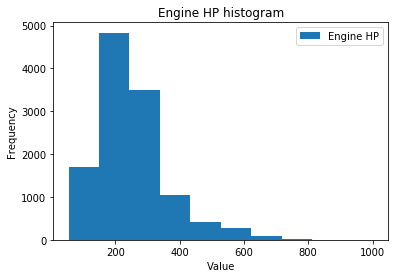

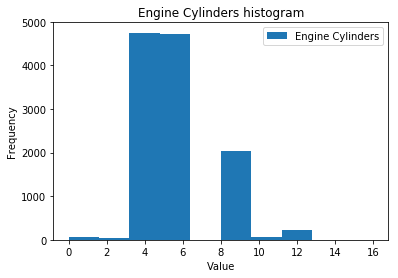

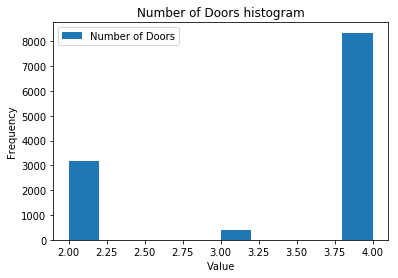

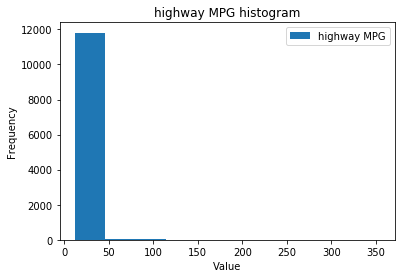

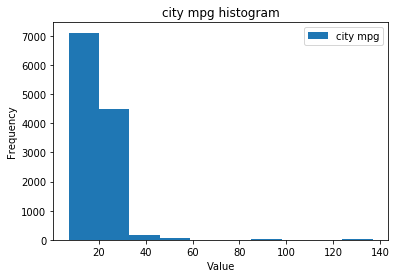

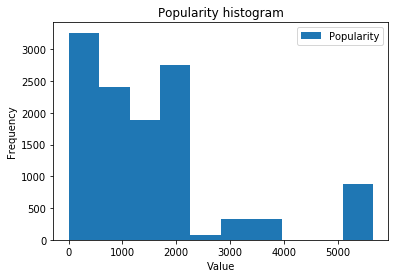

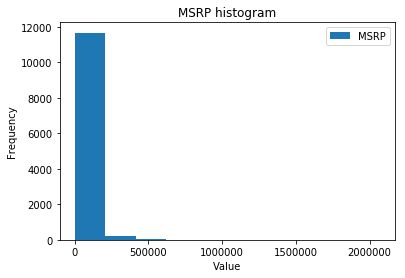

In [9]:
for col in numerical:
    ax = df[[col]].plot.hist(title=col + " histogram")
    ax.set_xlabel("Value")

- year, Engine HP, MPG, MSRP - Not very nice distribution => data transformation might help

=== Make ===
Chevrolet        0.094259
Ford             0.073947
Volkswagen       0.067903
Toyota           0.062615
Dodge            0.052543
Nissan           0.046836
GMC              0.043226
Honda            0.037687
Mazda            0.035504
Cadillac         0.033322
Mercedes-Benz    0.029629
Suzuki           0.029461
BMW              0.028034
Infiniti         0.027699
Audi             0.027531
Hyundai          0.025432
Volvo            0.023586
Subaru           0.021487
Acura            0.021152
Kia              0.019389
Mitsubishi       0.017878
Lexus            0.016955
Buick            0.016451
Chrysler         0.015696
Pontiac          0.015612
Lincoln          0.013765
Oldsmobile       0.012590
Land Rover       0.012003
Porsche          0.011415
Saab             0.009317
Aston Martin     0.007806
Plymouth         0.006883
Bentley          0.006211
Ferrari          0.005792
FIAT             0.005204
Scion            0.005036
Maserati         0.004868
Lamborghini      0.004365

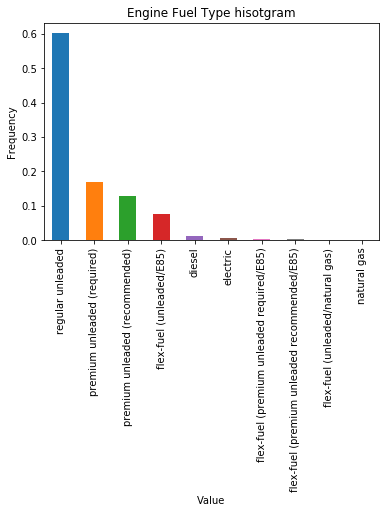

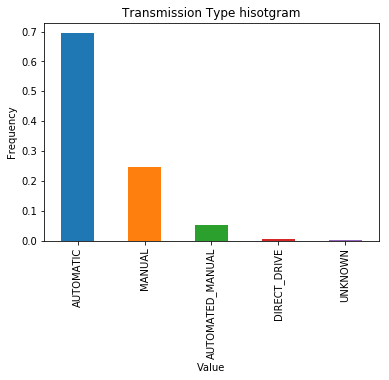

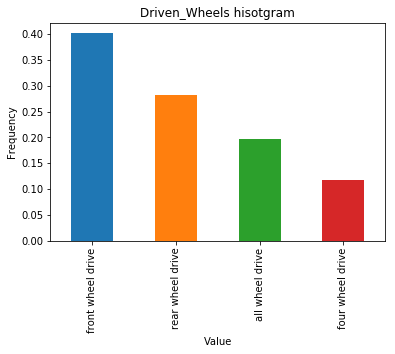

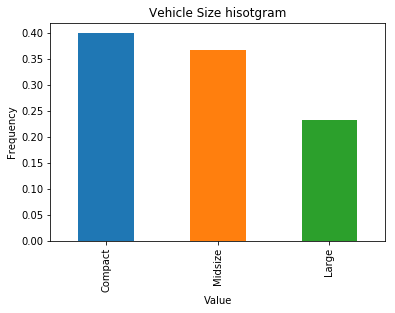

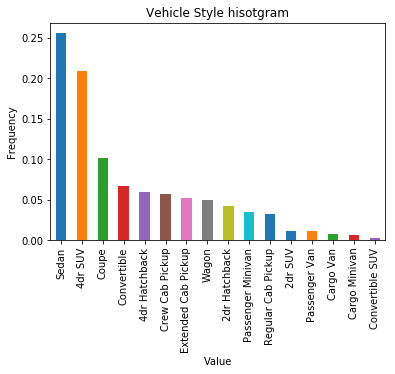

In [10]:
MAX_VALUES_TO_PLOT = 20

for col in categorical:
    value_counts = df[col].value_counts(normalize=True)
    if len(value_counts) <= MAX_VALUES_TO_PLOT:
        plt.figure()
        ax = value_counts.plot(kind='bar')
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_title(col + " hisotgram")
    else:
        print("=== {} ===".format(col))
        print(value_counts)
        print()

- "Market category" - more values, we should split
- "Engine Fuel type" - diesel => not a lot 
- "Driven_wheels" - all_wheel_drive and four_wheel_drive difference??? Maybe we can join to one category

# Correlations

In [11]:
df_corr = df.corr()
df_corr

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
Year,1.000000,0.351794,-0.041479,0.263787,0.258240,0.198171,0.073049,0.227590
Engine HP,0.351794,1.000000,0.779988,-0.102713,-0.406563,-0.439371,0.037501,0.662008
Engine Cylinders,-0.041479,0.779988,1.000000,-0.140088,-0.621606,-0.600776,0.041145,0.531312
Number of Doors,0.263787,-0.102713,-0.140088,1.000000,0.118570,0.120881,-0.048272,-0.126635
highway MPG,0.258240,-0.406563,-0.621606,0.118570,1.000000,0.886829,-0.020991,-0.160043
city mpg,0.198171,-0.439371,-0.600776,0.120881,0.886829,1.000000,-0.003217,-0.157676
Popularity,0.073049,0.037501,0.041145,-0.048272,-0.020991,-0.003217,1.000000,-0.048476
MSRP,0.227590,0.662008,0.531312,-0.126635,-0.160043,-0.157676,-0.048476,1.000000


Last colums tells me the potencial of the signal for prediction

### Get the most correlating pairs

In [12]:
CORR_THRESHOLD = 0.2

most_correlated_pairs = []

for i_col1, (col1, row) in enumerate(df_corr.items()):
    for i_col2, (col2, val) in enumerate(row.items()):
        
        # avoid duplicity and same columns
        if i_col1 <= i_col2:
            continue
            
        if abs(val) > CORR_THRESHOLD:
            most_correlated_pairs.append((col1, col2, val))
            
# Sort
most_correlated_pairs = sorted(most_correlated_pairs, key=lambda x: abs(x[2]), reverse=True)
most_correlated_pairs

[('city mpg', 'highway MPG', 0.8868294962591696),
 ('Engine Cylinders', 'Engine HP', 0.7799879704685222),
 ('MSRP', 'Engine HP', 0.6620076606110064),
 ('highway MPG', 'Engine Cylinders', -0.6216057332861424),
 ('city mpg', 'Engine Cylinders', -0.6007763119730104),
 ('MSRP', 'Engine Cylinders', 0.5313124863741728),
 ('city mpg', 'Engine HP', -0.43937125813556127),
 ('highway MPG', 'Engine HP', -0.4065625665782776),
 ('Engine HP', 'Year', 0.35179394240882894),
 ('Number of Doors', 'Year', 0.2637872829658482),
 ('highway MPG', 'Year', 0.25823982267572665),
 ('MSRP', 'Year', 0.2275895141047356)]

- MPG correlation - not a surprise
- Engine HP/cylinders - not a surprise
- MSRP, Engine HP/Cylinders => Engine will probably be the best predictor

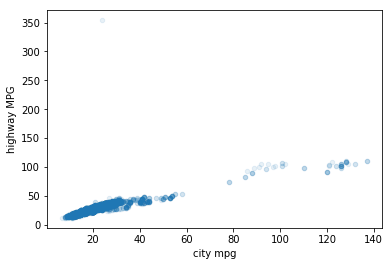

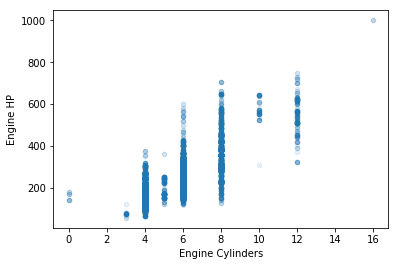

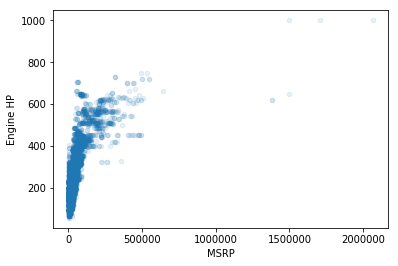

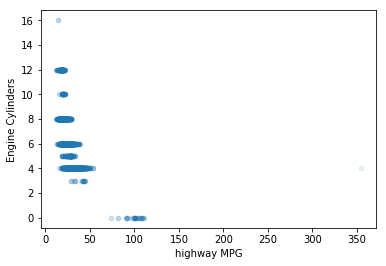

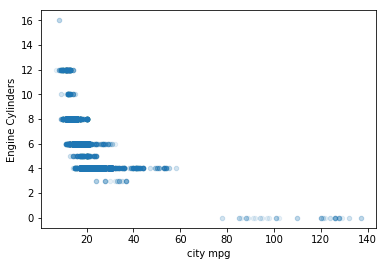

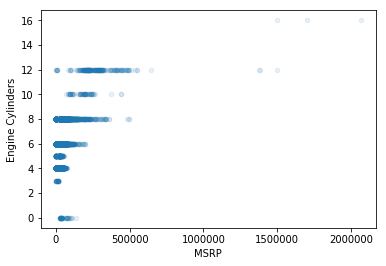

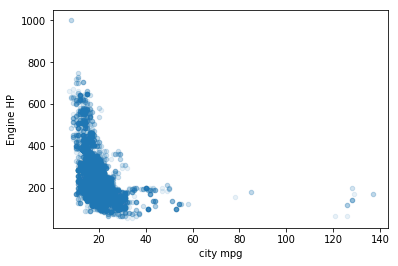

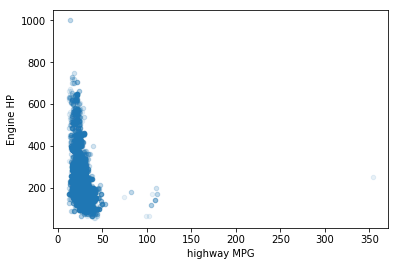

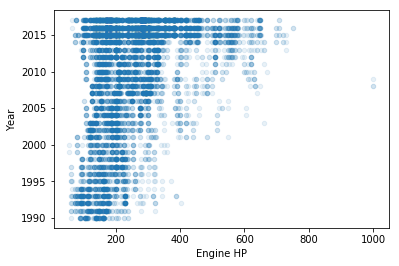

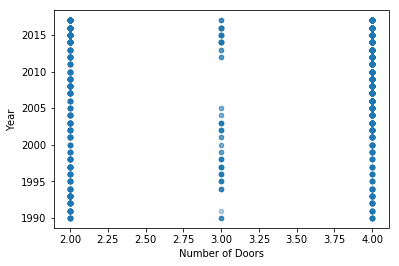

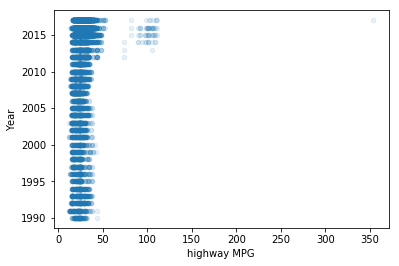

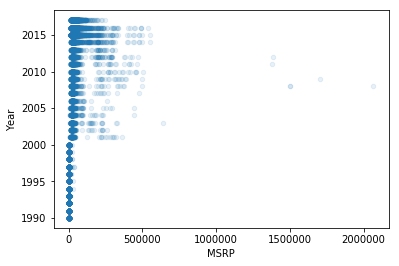

In [13]:
for col1, col2, val in most_correlated_pairs:
    df.plot.scatter(x=col1, y=col2, alpha=0.1)

- annomaly in Highway MPG => explore and correct/get rid of it
- most graphs not very linear, data transformation might be good idea
- over 1.5M too few examples => if it makes sense for the task get rid of it

### Plot the correlations with target

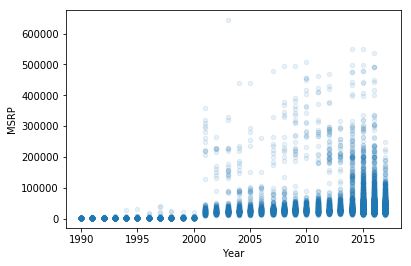

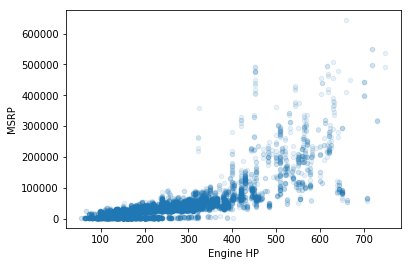

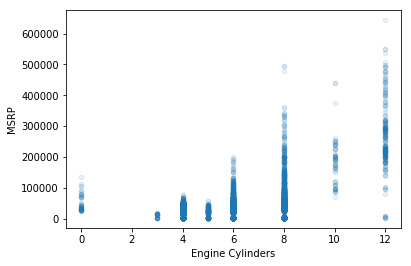

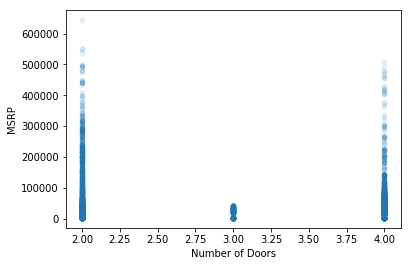

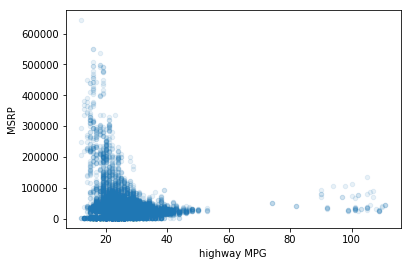

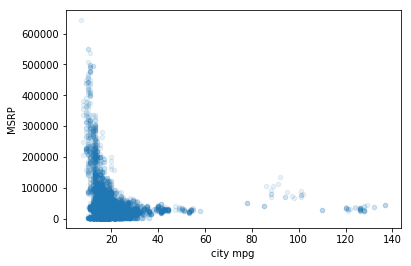

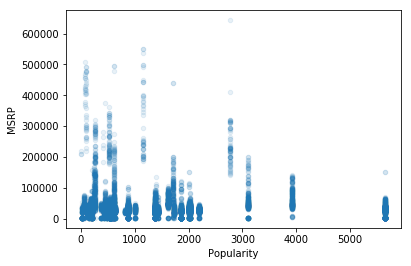

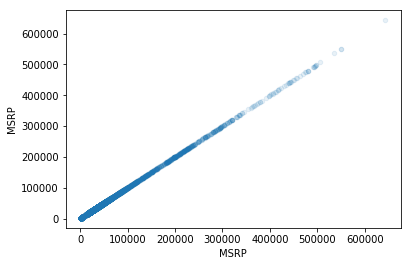

In [22]:
for col1 in numerical:
    df.plot.scatter(x=col1, y="MSRP", alpha=0.1)

# Transformations

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


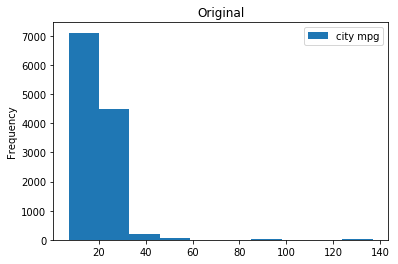

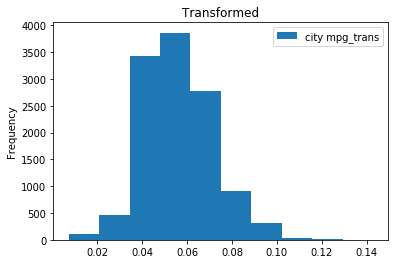

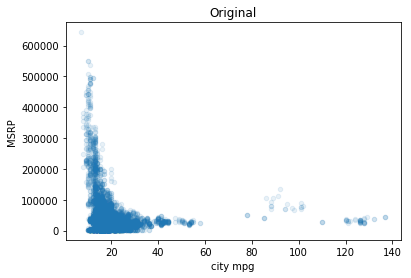

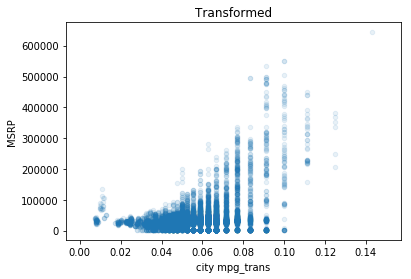

In [23]:
col = "city mpg"
col_trans = col+"_trans"

df.loc[:, col_trans] = 1/df[col]

df[[col]].plot.hist(title="Original")
df[[col_trans]].plot.hist(title="Transformed")

df.plot.scatter(x=col, y="MSRP", alpha=0.1, title="Original")
df.plot.scatter(x=col_trans, y="MSRP", alpha=0.1, title="Transformed")

del df[col_trans]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


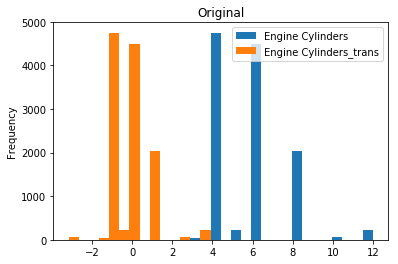

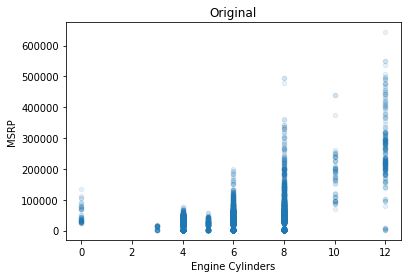

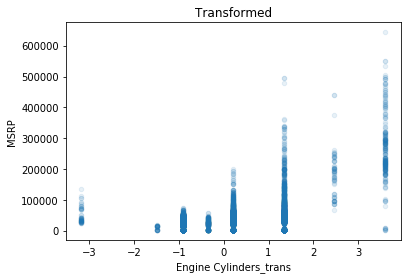

In [33]:
# col = "Number of Doors"
col = "Engine Cylinders"
col_trans = col+"_trans"

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.loc[:, col_trans] = scaler.fit_transform(df[[col]])

df[[col, col_trans]].plot.hist(title="Original", bins=30)
# df[[col_trans]].plot.hist(title="Transformed")

df.plot.scatter(x=col, y="MSRP", alpha=0.1, title="Original")
df.plot.scatter(x=col_trans, y="MSRP", alpha=0.1, title="Transformed")

del df[col_trans]

# Clean data

### Highway MPG

In [15]:
df[df["highway MPG"] > 300]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
1119,Audi,A6,2017,premium unleaded (recommended),252.0,4.0,AUTOMATED_MANUAL,front wheel drive,4.0,Luxury,Midsize,Sedan,354,24,3105,51600


In [16]:
df.loc[1119,"highway MPG"] = 35  # Not using /= 10 due to repetitive script trigger
df.loc[1119, :]

Make                                           Audi
Model                                            A6
Year                                           2017
Engine Fuel Type     premium unleaded (recommended)
Engine HP                                       252
Engine Cylinders                                  4
Transmission Type                  AUTOMATED_MANUAL
Driven_Wheels                     front wheel drive
Number of Doors                                   4
Market Category                              Luxury
Vehicle Size                                Midsize
Vehicle Style                                 Sedan
highway MPG                                      35
city mpg                                         24
Popularity                                     3105
MSRP                                          51600
Name: 1119, dtype: object

### MSRP

In [17]:
print(df.shape)
df[df["MSRP"] > 1000000]

(11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
6350,Maybach,Landaulet,2011,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,High-Performance",Large,Convertible,16,10,67,1380000
6351,Maybach,Landaulet,2012,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,Performance",Large,Convertible,16,10,67,1382750
8486,Lamborghini,Reventon,2008,premium unleaded (required),650.0,12.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,9,1158,1500000
11362,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,2065902
11363,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1500000
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1705769


In [18]:
df = df[df["MSRP"] <= 1000000]
print(df.shape)
df[df["MSRP"] > 1000000]

(11908, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP


# Split to train/dev/test set

In [18]:
from sklearn.model_selection import train_test_split

def train_dev_test_split(d, sizes):
    train_dev, test = train_test_split(df, test_size=splits[2], random_state=1)
    test_size = splits[1] / sum(splits[:2])  # to get 20% of the total, not 20% of  the 80%
    train, dev = train_test_split(train_dev, test_size=test_size, random_state=1)
    
    return train, dev, test

splits = (0.6, 0.2, 0.2)
datasets = {}
datasets["train"], datasets["dev"], datasets["test"] = train_dev_test_split(df, splits)


for name, dataset in datasets.items():
    print("{} len={}, {}".format(name, len(dataset), len(dataset)/len(df)))

train len=7144, 0.5999328182734296
dev len=2382, 0.20003359086328518
test len=2382, 0.20003359086328518


In [19]:
for name, dataset in datasets.items():
    dataset.to_csv("data/data_clean_{}.csv".format(name))